Found 10 subject files. Processing...
  Processing mHealth_subject1...
    mHealth_subject1: Loaded dataframe with shape (161280, 24)
    mHealth_subject1: 35174 valid samples after filtering.
    mHealth_subject1: Created 548 windows.
  Processing mHealth_subject10...
    mHealth_subject10: Loaded dataframe with shape (98304, 24)
    mHealth_subject10: 33690 valid samples after filtering.
    mHealth_subject10: Created 525 windows.
  Processing mHealth_subject2...
    mHealth_subject2: Loaded dataframe with shape (130561, 24)
    mHealth_subject2: 35532 valid samples after filtering.
    mHealth_subject2: Created 554 windows.
  Processing mHealth_subject3...
    mHealth_subject3: Loaded dataframe with shape (122112, 24)
    mHealth_subject3: 35380 valid samples after filtering.
    mHealth_subject3: Created 551 windows.
  Processing mHealth_subject4...
    mHealth_subject4: Loaded dataframe with shape (116736, 24)
    mHealth_subject4: 35328 valid samples after filtering.
    mHealth_

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/20 | Train Loss: 0.3958, Acc: 0.8900 | Val Loss: 0.0467, Acc: 0.9907
Epoch 2/20 | Train Loss: 0.1079, Acc: 0.9707 | Val Loss: 0.1100, Acc: 0.9589
Epoch 3/20 | Train Loss: 0.0705, Acc: 0.9800 | Val Loss: 0.0227, Acc: 0.9935
Epoch 4/20 | Train Loss: 0.0857, Acc: 0.9788 | Val Loss: 0.0201, Acc: 0.9953
Epoch 5/20 | Train Loss: 0.0208, Acc: 0.9938 | Val Loss: 0.0274, Acc: 0.9963
Epoch 6/20 | Train Loss: 0.0285, Acc: 0.9941 | Val Loss: 0.0292, Acc: 0.9944
Epoch 7/20 | Train Loss: 0.0752, Acc: 0.9807 | Val Loss: 0.0304, Acc: 0.9888
Epoch 8/20 | Train Loss: 0.0333, Acc: 0.9900 | Val Loss: 0.0331, Acc: 0.9916
Epoch 9/20 | Train Loss: 0.0925, Acc: 0.9769 | Val Loss: 0.0262, Acc: 0.9935
Epoch 10/20 | Train Loss: 0.0208, Acc: 0.9925 | Val Loss: 0.0123, Acc: 0.9953
Epoch 11/20 | Train Loss: 0.0146, Acc: 0.9963 | Val Loss: 0.0084, Acc: 0.9963
Epoch 12/20 | Train Loss: 0.0162, Acc: 0.9953 | Val Loss: 0.0100, Acc: 0.9953
Epoch 13/20 | Train Loss: 0.0290, Acc: 0.9931 | Val Loss: 0.0066, Acc: 0.

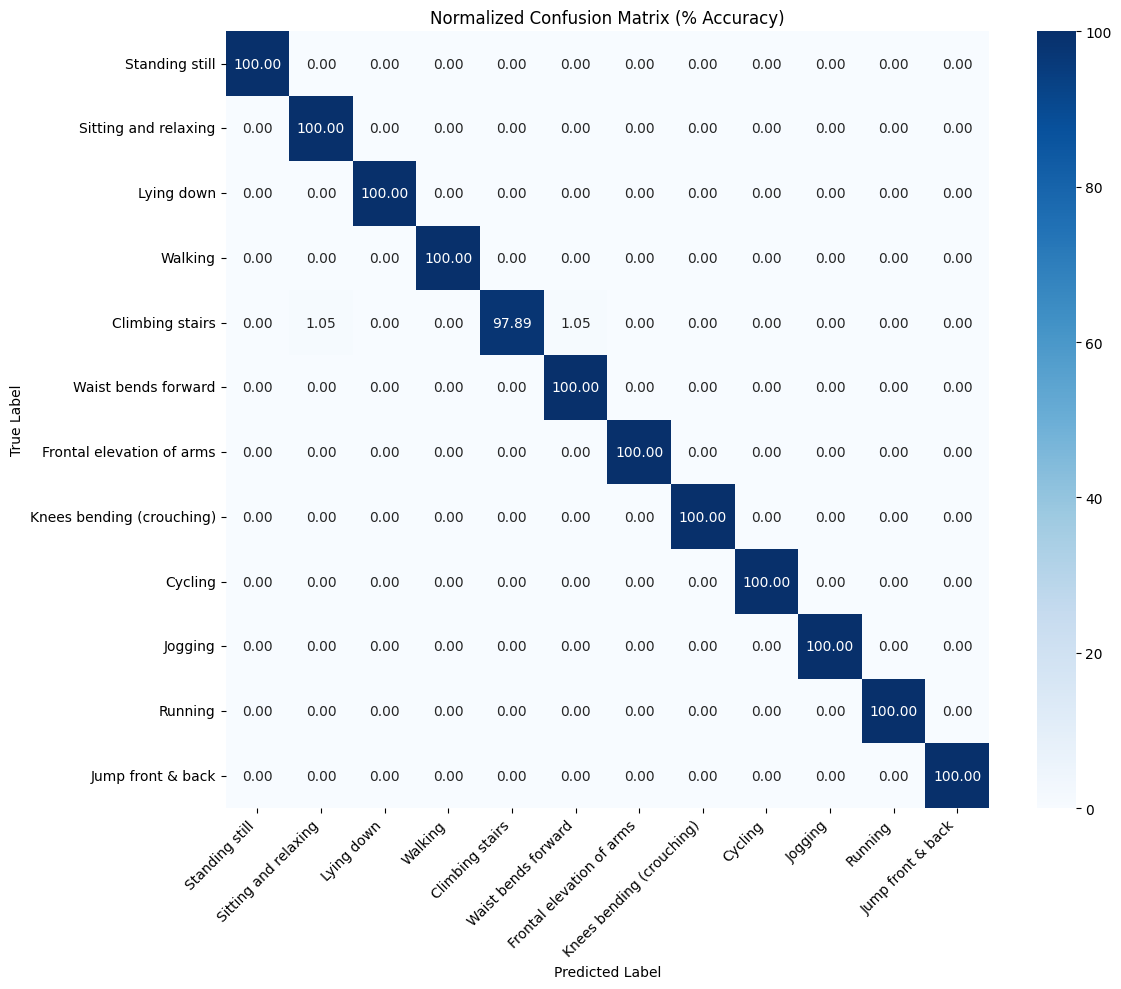

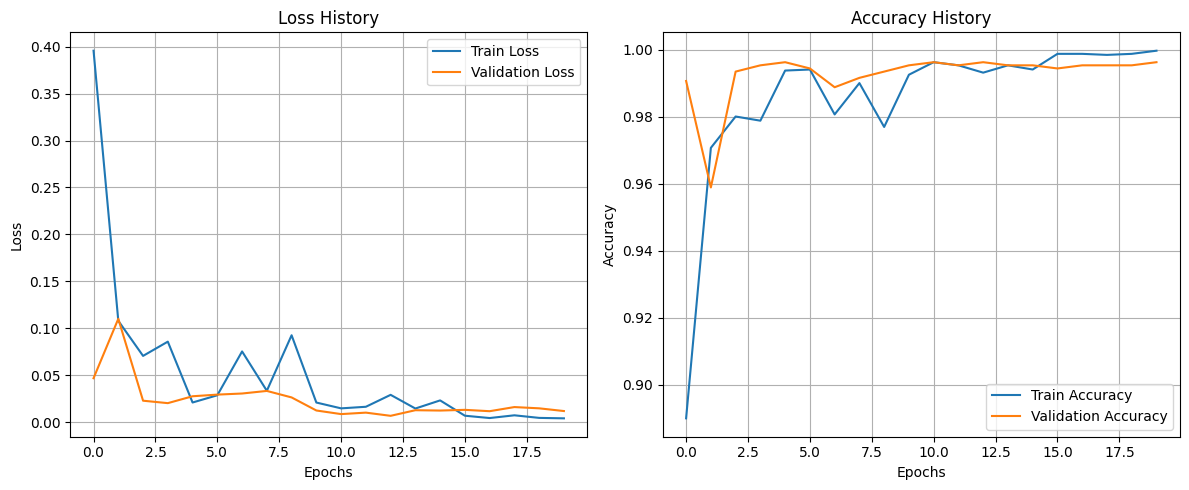


No history data to plot.

Final Test Accuracy: 0.9981


In [1]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import glob # To find subject files


# ---------------- Depthwise Separable Conv ----------------
class DepthwiseSeparableConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, padding, bias=False):
        super().__init__()
        self.depthwise = nn.Conv1d(in_channels, in_channels, kernel_size=kernel_size,
                                        padding=padding, groups=in_channels, bias=bias)
        self.pointwise = nn.Conv1d(in_channels, out_channels, kernel_size=1, bias=bias)
        self.bn = nn.BatchNorm1d(out_channels)
        self.relu = nn.ReLU(inplace=True)
    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        x = self.bn(x)
        return self.relu(x)

# ---------------- MultiKernalBlock ----------------
class MultiKernalBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.skip_proj = nn.Conv1d(in_channels, out_channels * 4, kernel_size=1, bias=False)
        self.bn_skip = nn.BatchNorm1d(out_channels * 4)
        self.branch7 = DepthwiseSeparableConv(in_channels, out_channels, kernel_size=7, padding=3)
        self.branch5 = DepthwiseSeparableConv(out_channels, out_channels, kernel_size=5, padding=2)
        self.branch3 = DepthwiseSeparableConv(out_channels, out_channels, kernel_size=3, padding=1)
        self.branch1 = DepthwiseSeparableConv(out_channels, out_channels, kernel_size=1, padding=0)
    def forward(self, x):
        identity = self.bn_skip(self.skip_proj(x))
        x7 = self.branch7(x)
        x5 = self.branch5(x7)
        x3 = self.branch3(x5)
        x1 = self.branch1(x3)
        out = torch.cat([x1, x3, x5, x7], dim=1)
        out = out + identity
        return F.relu(out)

# ---------------- InceptionBlock ----------------
class InceptionBlock(nn.Module):
    def __init__(self, in_channels, out_channels_per_branch):
        super().__init__()
        total_out_channels = out_channels_per_branch * 4
        self.skip_proj = nn.Conv1d(in_channels, total_out_channels, kernel_size=1, bias=False)
        self.bn_skip = nn.BatchNorm1d(total_out_channels)
        self.branch1 = DepthwiseSeparableConv(in_channels, out_channels_per_branch, kernel_size=1, padding=0)
        self.branch3 = nn.Sequential(
            DepthwiseSeparableConv(in_channels, out_channels_per_branch, kernel_size=1, padding=0),
            DepthwiseSeparableConv(out_channels_per_branch, out_channels_per_branch, kernel_size=3, padding=1)
        )
        self.branch5 = nn.Sequential(
            DepthwiseSeparableConv(in_channels, out_channels_per_branch, kernel_size=1, padding=0),
            DepthwiseSeparableConv(out_channels_per_branch, out_channels_per_branch, kernel_size=5, padding=2)
        )
        self.pool = nn.Sequential(
            nn.MaxPool1d(kernel_size=3, stride=1, padding=1),
            DepthwiseSeparableConv(in_channels, out_channels_per_branch, kernel_size=1, padding=0)
        )
    def forward(self, x):
        identity = self.bn_skip(self.skip_proj(x))
        b1 = self.branch1(x)
        b3 = self.branch3(x)
        b5 = self.branch5(x)
        bp = self.pool(x)
        out = torch.cat([b1, b3, b5, bp], dim=1)
        out = out + identity
        return F.relu(out)

# ---------------- ResidualBlock----------------
class ResidualBlock(nn.Module):
    def __init__(self, channels, kernel_size=3):
        super().__init__()
        self.conv1 = nn.Conv1d(channels, channels, kernel_size, padding=kernel_size // 2, bias=False)
        self.bn1 = nn.BatchNorm1d(channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv1d(channels, channels, kernel_size, padding=kernel_size // 2, bias=False)
        self.bn2 = nn.BatchNorm1d(channels)
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += residual
        return self.relu(out)

# ---------------- TransformerEncoderBlock ----------------
class TransformerEncoderBlock(nn.Module):
    def __init__(self, dim, num_heads, dropout=0.1):
        super().__init__()
        self.attn = nn.MultiheadAttention(embed_dim=dim, num_heads=num_heads, batch_first=True, dropout=dropout)
        self.ffn = nn.Sequential(
            nn.Linear(dim, dim * 4), nn.ReLU(), nn.Dropout(dropout), nn.Linear(dim * 4, dim)
        )
        self.norm1 = nn.LayerNorm(dim)
        self.norm2 = nn.LayerNorm(dim)
        self.dropout = nn.Dropout(dropout)
    def forward(self, x):
        x_norm1 = self.norm1(x)
        attn_out, _ = self.attn(x_norm1, x_norm1, x_norm1)
        x = x + self.dropout(attn_out)
        x_norm2 = self.norm2(x)
        ffn_out = self.ffn(x_norm2)
        x = x + self.dropout(ffn_out)
        return x

# ---------------- InceptionFormer ----------------
class InceptionFormer(nn.Module):
    # Keep the InceptionFormer class definition as in the previous version
    def __init__(self, input_channels=9, feature_dim=64, num_classes=6, num_transformer_layers=2, num_heads=4, dropout=0.1):
        super().__init__()
        self.input_proj = nn.Conv1d(input_channels, feature_dim, kernel_size=1, bias=False)
        self.input_bn = nn.BatchNorm1d(feature_dim)
        self.inception = InceptionBlock(feature_dim, feature_dim)
        self.mkls = MultiKernalBlock(feature_dim * 4, feature_dim)
        self.residual1 = ResidualBlock(feature_dim * 4)
        self.transformer_layers = nn.ModuleList([
            TransformerEncoderBlock(dim=feature_dim * 4, num_heads=num_heads, dropout=dropout)
            for _ in range(num_transformer_layers)
        ])
        self.gap = nn.AdaptiveAvgPool1d(1)
        self.flatten = nn.Flatten()
        self.classifier = nn.Sequential(
            nn.LayerNorm(feature_dim * 4), nn.Linear(feature_dim * 4, 128), nn.ReLU(),
            nn.Dropout(dropout), nn.Linear(128, num_classes)
        )
    def forward(self, x):
        x = F.relu(self.input_bn(self.input_proj(x)))
        x = self.inception(x)
        x = self.mkls(x)
        x = self.residual1(x)
        x = x.permute(0, 2, 1)
        for layer in self.transformer_layers:
            x = layer(x)
        x = x.permute(0, 2, 1)
        x = self.gap(x)
        x = self.flatten(x)
        return self.classifier(x)

# ==============================================================================
# Data Loading and Dataset for MHEALTH
# ==============================================================================
import os
import numpy as np
import pandas as pd
from collections import Counter
from sklearn.preprocessing import LabelEncoder

import os
import numpy as np
import pandas as pd
import torch
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset

import os
import numpy as np
import pandas as pd
import torch
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset

def load_and_window_mhealth(dataset_dir, selected_columns, label_column_index, window_size=200, step=200, exclude_label=0):
    subject_files = sorted([
        os.path.join(dataset_dir, f)
        for f in os.listdir(dataset_dir)
        if f.startswith("mHealth_subject") and f.endswith(".log")
    ])

    if not subject_files:
        print(f"Error: No 'mHealth_subject*.log' files found in directory: {dataset_dir}. Please ensure the path is correct.")
        return None, None, None, None

    print(f"Found {len(subject_files)} subject files. Processing...")

    all_windows, all_labels = [], []
    original_labels_collected = []
    label_encoder = LabelEncoder()

    for file_path in subject_files:
        subject_id = os.path.basename(file_path).split('.')[0]
        print(f"  Processing {subject_id}...")

        try:
            df = pd.read_csv(file_path, sep='\s+', header=None, engine='python', dtype=np.float32)
            print(f"    {subject_id}: Loaded dataframe with shape {df.shape}")


            required_max_index = max(selected_columns + [label_column_index])
            if df.shape[1] < required_max_index + 1:
                print(f"    Skipping {subject_id}: Not enough columns (found {df.shape[1]}). Required ≥ {required_max_index + 1}. Check SELECTED_COLUMNS and LABEL_COLUMN_INDEX.")
                continue

            labels = df.iloc[:, label_column_index].values.astype(int)
            features = df.iloc[:, selected_columns].values

            valid_indices = np.where(labels != exclude_label)[0]
            if len(valid_indices) == 0:
                print(f"    Skipping {subject_id}: No valid activities after excluding label {exclude_label}.")
                continue

            features = features[valid_indices, :]
            labels = labels[valid_indices]

            print(f"    {subject_id}: {len(features)} valid samples after filtering.")

            if len(features) < window_size:
                print(f"    Skipping {subject_id}: Not enough data for one window (need {window_size}, got {len(features)}). Consider reducing WINDOW_SIZE.")
                continue

            original_labels_collected.extend(labels)

            subject_windows, subject_window_labels = [], []
            start = 0
            while start + window_size <= len(features):
                window_data = features[start : start + window_size, :]
                window_labels_raw = labels[start : start + window_size]
                most_common_label = Counter(window_labels_raw).most_common(1)[0][0]

                subject_windows.append(window_data)
                subject_window_labels.append(most_common_label)
                start += step

            if subject_windows:
                all_windows.extend(subject_windows)
                all_labels.extend(subject_window_labels)
                print(f"    {subject_id}: Created {len(subject_windows)} windows.")
            else:
                print(f"    No windows created for {subject_id} (data might be too short for window_size={window_size}).")

        except pd.errors.EmptyDataError:
            print(f"    Skipping {subject_id}: File is empty.")
        except Exception as e:
            print(f"    Error processing {subject_id}: {e}")

    if not all_windows:
        print("Error: No windows were created from any subject file. Check the dataset directory, file formats, and windowing parameters.")
        return None, None, None, None

    label_encoder.fit(sorted(set(original_labels_collected)))
    y_encoded = label_encoder.transform(all_labels)
    class_names = list(label_encoder.classes_)
    num_classes_actual = len(np.unique(y_encoded))

    X_windowed = np.array(all_windows, dtype=np.float32)
    X_windowed = np.transpose(X_windowed, (0, 2, 1))

    print(f"\nWindowing complete. Total windows: {X_windowed.shape[0]}")
    print(f"  Windowed data shape (N, C, L): {X_windowed.shape}")
    print(f"  Encoded labels shape: {y_encoded.shape}")
    print(f"  Unique encoded labels found: {np.unique(y_encoded)}")
    print(f"  Number of classes after encoding: {num_classes_actual}")
    print(f"  Original Class names mapped by encoder: {class_names}")

    mhealth_activity_names = [
        'Standing still', 'Sitting and relaxing', 'Lying down', 'Walking',
        'Climbing stairs', 'Waist bends forward', 'Frontal elevation of arms',
        'Knees bending (crouching)', 'Cycling', 'Jogging', 'Running', 'Jump front & back'
    ]

    if len(mhealth_activity_names) != num_classes_actual:
        print(f"Warning: Activity names mismatch: expected {num_classes_actual}, got {len(mhealth_activity_names)}. Using found class names.")
        report_class_names = class_names
    else:
        report_class_names = mhealth_activity_names

    return X_windowed, y_encoded, report_class_names, num_classes_actual



class MHealthDataset(Dataset):
    """MHEALTH windowed data PyTorch Dataset"""
    def __init__(self, data, labels):
        if data.ndim != 3:
            raise ValueError(f"Data needs to be 3D (samples, channels, sequence), but got {data.shape}")
        self.data = torch.tensor(data, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, device, epochs=30, patience=5):
    """Trains and validates the model, includes early stopping."""
    print(f"\n=== Model Training Started (Device: {device}) ===")
    best_val_loss = float('inf')
    best_epoch = 0
    epochs_no_improve = 0
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    best_model_state = None
    for epoch in range(epochs):
        model.train()
        running_loss, correct_train, total_train = 0.0, 0, 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
        epoch_train_loss = running_loss / total_train
        epoch_train_acc = correct_train / total_train
        history['train_loss'].append(epoch_train_loss)
        history['train_acc'].append(epoch_train_acc)

        model.eval()
        running_val_loss, correct_val, total_val = 0.0, 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()
        epoch_val_loss = running_val_loss / total_val
        epoch_val_acc = correct_val / total_val
        history['val_loss'].append(epoch_val_loss)
        history['val_acc'].append(epoch_val_acc)

        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {epoch_train_loss:.4f}, Acc: {epoch_train_acc:.4f} | Val Loss: {epoch_val_loss:.4f}, Acc: {epoch_val_acc:.4f}")
        scheduler.step(epoch_val_loss)
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            best_epoch = epoch + 1
            epochs_no_improve = 0
            best_model_state = model.state_dict()
            # print(f"  -> Val loss decreased to {best_val_loss:.4f}. Saving model.") # Optional: Verbose saving message
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"\nEarly stopping after {epoch+1} epochs.")
                break
    print(f"=== Training Finished ===")
    if best_model_state:
        print(f"Loading best model from epoch {best_epoch} (Val Loss: {best_val_loss:.4f})")
        model.load_state_dict(best_model_state)
    return model, history


import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

def evaluate_model(model, test_loader, criterion, device, class_names):
    """Evaluates the final model on the test dataset, shows accuracy in % and a normalized confusion matrix."""
    print("\n=== Final Model Evaluation (Test Set) ===")
    model.eval()
    running_test_loss = 0.0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            if criterion is not None:
                loss = criterion(outputs, labels)
                running_test_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # 손실과 정확도 계산
    test_loss = (running_test_loss / len(test_loader.dataset)
                 if criterion is not None and len(test_loader.dataset) > 0
                 else -1.0)
    test_accuracy = accuracy_score(all_labels, all_preds)
    test_accuracy_pct = test_accuracy * 100

    print(f"Test Loss: {test_loss:.4f}" if test_loss != -1.0 else "Test Loss: N/A")
    print(f"Test Accuracy: {test_accuracy_pct:.2f}%")

    # 분류 리포트
    print("\nClassification Report:")
    unique_labels = np.unique(all_labels)
    report_names = [class_names[i] for i in unique_labels if i < len(class_names)]
    if len(report_names) != len(unique_labels):
        print("Warning: Label mismatch for report. Using numeric labels.")
        report_names = None

    print(classification_report(
        all_labels, all_preds,
        target_names=report_names,
        digits=4,
        zero_division=0
    ))

    # 정규화된 혼동행렬 계산 (클래스별 정확도)
    cm = confusion_matrix(all_labels, all_preds)
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100  # 백분율로 변환

    plt.figure(figsize=(12, 10))
    sns.heatmap(
        cm_norm,
        annot=True,
        fmt=".2f",
        cmap="Blues",
        xticklabels=report_names if report_names else unique_labels,
        yticklabels=report_names if report_names else unique_labels
    )
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Normalized Confusion Matrix (% Accuracy)')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    return test_loss, test_accuracy




# ==============================================================================
if __name__ == '__main__':

    MHEALTH_DATASET_PATH = '/content/drive/MyDrive/Colab Notebooks/MHEALTHDATASET'
    RANDOM_STATE = 42

    SELECTED_COLUMNS = [0, 1, 2, 3, 4, 5,  # Chest Acc, Gyro
                        9, 10, 11, 12, 13, 14, # Ankle Acc, Gyro
                        18, 19, 20, 21, 22, 23] # Wrist Acc, Gyro
    LABEL_COLUMN_INDEX = 23
    EXCLUDE_LABEL = 0      # Label 0 is the Null class in MHEALTH

    # Windowing Parameters (MHEALTH is often 50Hz)
    WINDOW_SIZE = 128      # Approx 2.56 seconds at 50Hz
    STEP = 64              # 50% overlap

    # Data Splitting Parameters
    TEST_SPLIT_SIZE = 0.2
    VAL_SPLIT_SIZE = 0.2

    # Training Parameters
    BATCH_SIZE = 64
    EPOCHS = 20          # Might need more epochs
    LEARNING_RATE = 0.0005 # Slightly lower LR
    PATIENCE = 10          # Early stopping patience

    # Model Parameters
    INPUT_CHANNELS = len(SELECTED_COLUMNS) # Determined by selected sensor columns
    FEATURE_DIM = 128
    NUM_TRANSFORMER_LAYERS = 3
    NUM_HEADS = 8
    DROPOUT = 0.25         # Slightly increased dropout

    # Set seed for reproducibility
    np.random.seed(RANDOM_STATE)
    torch.manual_seed(RANDOM_STATE)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(RANDOM_STATE)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

    # --- 1. Load and Window Data ---
    X_windowed, y_encoded, CLASS_NAMES, NUM_CLASSES = load_and_window_mhealth(
        dataset_dir=MHEALTH_DATASET_PATH,
        selected_columns=SELECTED_COLUMNS,
        label_column_index=LABEL_COLUMN_INDEX,
        window_size=WINDOW_SIZE,
        step=STEP,
        exclude_label=EXCLUDE_LABEL
    )

    if X_windowed is not None and y_encoded is not None:
        INPUT_CHANNELS = X_windowed.shape[1]
        SEQUENCE_LENGTH = X_windowed.shape[2]

        print(f"\n✅ Data loading successful.")
        print(f"Input Channels: {INPUT_CHANNELS}, Sequence Length: {SEQUENCE_LENGTH}, Num Classes: {NUM_CLASSES}")
        print(f"Class Names: {CLASS_NAMES}")

        # --- 2. Split Data ---
        X_temp, X_test, y_temp, y_test = train_test_split(
            X_windowed, y_encoded, test_size=TEST_SPLIT_SIZE, random_state=RANDOM_STATE, stratify=y_encoded
        )
        relative_val_size = VAL_SPLIT_SIZE / (1.0 - TEST_SPLIT_SIZE)
        X_train, X_val, y_train, y_val = train_test_split(
            X_temp, y_temp, test_size=relative_val_size, random_state=RANDOM_STATE, stratify=y_temp
        )

        print("\n Data Split Shapes:")
        print(f"  Train: X={X_train.shape}, y={y_train.shape}")
        print(f"  Val:   X={X_val.shape}, y={y_val.shape}")
        print(f"  Test:  X={X_test.shape}, y={y_test.shape}")

        # --- 3. Apply Scaling (Fit on Train only) ---
        scaler = StandardScaler()
        # Reshape X_train: (N, C, L) -> (N*L, C) -> Scale -> (N, L, C) -> (N, C, L)
        n_train, c_train, l_train = X_train.shape
        X_train_reshaped = X_train.transpose(0, 2, 1).reshape(-1, c_train)
        scaler.fit(X_train_reshaped)
        X_train_scaled_reshaped = scaler.transform(X_train_reshaped)
        X_train = X_train_scaled_reshaped.reshape(n_train, l_train, c_train).transpose(0, 2, 1)

        # Reshape and Transform X_val
        n_val, c_val, l_val = X_val.shape
        X_val_reshaped = X_val.transpose(0, 2, 1).reshape(-1, c_val)
        X_val_scaled_reshaped = scaler.transform(X_val_reshaped)
        X_val = X_val_scaled_reshaped.reshape(n_val, l_val, c_val).transpose(0, 2, 1)

        # Reshape and Transform X_test
        n_test, c_test, l_test = X_test.shape
        X_test_reshaped = X_test.transpose(0, 2, 1).reshape(-1, c_test)
        X_test_scaled_reshaped = scaler.transform(X_test_reshaped)
        X_test = X_test_scaled_reshaped.reshape(n_test, l_test, c_test).transpose(0, 2, 1)
        print("Data scaling applied (fitted on train set).")

        # --- 4. Calculate Class Weights (using training set only) ---
        class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
        class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32)
        print(f"\nClass Weights (for training loss): {class_weights}")

        # --- 5. Create Datasets and DataLoaders ---
        train_dataset = MHealthDataset(X_train, y_train) # Use renamed dataset
        val_dataset = MHealthDataset(X_val, y_val)
        test_dataset = MHealthDataset(X_test, y_test)

        train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
        val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE * 2, shuffle=False, num_workers=2, pin_memory=True)
        test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE * 2, shuffle=False, num_workers=2, pin_memory=True)
        print("DataLoaders created.")

        # --- 6. Initialize Model, Loss, Optimizer, Scheduler ---
        model = InceptionFormer(input_channels=INPUT_CHANNELS,
                                     feature_dim=FEATURE_DIM,
                                     num_classes=NUM_CLASSES,
                                     num_transformer_layers=NUM_TRANSFORMER_LAYERS,
                                     num_heads=NUM_HEADS,
                                     dropout=DROPOUT)

        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model.to(device)
        class_weights_tensor = class_weights_tensor.to(device) # Move weights to device

        criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
        optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=0.01)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.2, patience=4, verbose=True) # Adjusted patience

        print(f"\nModel Initialized: {type(model).__name__}")
        print(f"  Input Channels: {INPUT_CHANNELS}")
        print(f"  Num Classes: {NUM_CLASSES}")
        print(f"Using device: {device}")

        # --- 7. Train the Model ---
        trained_model, history = train_model(model=model,
                                                             train_loader=train_loader,
                                                             val_loader=val_loader,
                                                             criterion=criterion,
                                                             optimizer=optimizer,
                                                             scheduler=scheduler,
                                                             device=device,
                                                             epochs=EPOCHS,
                                                             patience=PATIENCE)

        # --- 8. Evaluate the Final Model on Test Set ---
        test_loss, test_accuracy = evaluate_model(model=trained_model,
                                                                 test_loader=test_loader,
                                                                 criterion=criterion,
                                                                 device=device,
                                                                 class_names=CLASS_NAMES) # Use the defined MHEALTH names

        # --- 9. Plot Training History ---
        if history:
            plt.figure(figsize=(12, 5))
            plt.subplot(1, 2, 1)
            plt.plot(history['train_loss'], label='Train Loss')
            plt.plot(history['val_loss'], label='Validation Loss')
            plt.title('Loss History')
            plt.xlabel('Epochs'); plt.ylabel('Loss'); plt.legend(); plt.grid(True)
            plt.subplot(1, 2, 2)
            plt.plot(history['train_acc'], label='Train Accuracy')
            plt.plot(history['val_acc'], label='Validation Accuracy')
            plt.title('Accuracy History')
            plt.xlabel('Epochs'); plt.ylabel('Accuracy'); plt.legend(); plt.grid(True)
            plt.tight_layout(); plt.show()
            print("\nNo history data to plot.")

        print(f"\nFinal Test Accuracy: {test_accuracy:.4f}")

    else:
        print("\nData loading or windowing failed. Exiting.")

In [2]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import glob # To find subject files


# ---------------- Depthwise Separable Conv ----------------
class DepthwiseSeparableConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, padding, bias=False):
        super().__init__()
        self.depthwise = nn.Conv1d(in_channels, in_channels, kernel_size=kernel_size,
                                     padding=padding, groups=in_channels, bias=bias)
        self.pointwise = nn.Conv1d(in_channels, out_channels, kernel_size=1, bias=bias)
        self.bn = nn.BatchNorm1d(out_channels)
        self.relu = nn.ReLU(inplace=True)
    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        x = self.bn(x)
        return self.relu(x)

# ---------------- MultiKernalBlock ----------------
class MultiKernalBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.skip_proj = nn.Conv1d(in_channels, out_channels * 4, kernel_size=1, bias=False)
        self.bn_skip = nn.BatchNorm1d(out_channels * 4)
        self.branch7 = DepthwiseSeparableConv(in_channels, out_channels, kernel_size=7, padding=3)
        self.branch5 = DepthwiseSeparableConv(out_channels, out_channels, kernel_size=5, padding=2)
        self.branch3 = DepthwiseSeparableConv(out_channels, out_channels, kernel_size=3, padding=1)
        self.branch1 = DepthwiseSeparableConv(out_channels, out_channels, kernel_size=1, padding=0)
    def forward(self, x):
        identity = self.bn_skip(self.skip_proj(x))
        x7 = self.branch7(x)
        x5 = self.branch5(x7)
        x3 = self.branch3(x5)
        x1 = self.branch1(x3)
        out = torch.cat([x1, x3, x5, x7], dim=1)
        out = out + identity
        return F.relu(out)

# ---------------- InceptionBlock ----------------
class InceptionBlock(nn.Module):
    def __init__(self, in_channels, out_channels_per_branch):
        super().__init__()
        total_out_channels = out_channels_per_branch * 4
        self.skip_proj = nn.Conv1d(in_channels, total_out_channels, kernel_size=1, bias=False)
        self.bn_skip = nn.BatchNorm1d(total_out_channels)
        self.branch1 = DepthwiseSeparableConv(in_channels, out_channels_per_branch, kernel_size=1, padding=0)
        self.branch3 = nn.Sequential(
            DepthwiseSeparableConv(in_channels, out_channels_per_branch, kernel_size=1, padding=0),
            DepthwiseSeparableConv(out_channels_per_branch, out_channels_per_branch, kernel_size=3, padding=1)
        )
        self.branch5 = nn.Sequential(
            DepthwiseSeparableConv(in_channels, out_channels_per_branch, kernel_size=1, padding=0),
            DepthwiseSeparableConv(out_channels_per_branch, out_channels_per_branch, kernel_size=5, padding=2)
        )
        self.pool = nn.Sequential(
            nn.MaxPool1d(kernel_size=3, stride=1, padding=1),
            DepthwiseSeparableConv(in_channels, out_channels_per_branch, kernel_size=1, padding=0)
        )
    def forward(self, x):
        identity = self.bn_skip(self.skip_proj(x))
        b1 = self.branch1(x)
        b3 = self.branch3(x)
        b5 = self.branch5(x)
        bp = self.pool(x)
        out = torch.cat([b1, b3, b5, bp], dim=1)
        out = out + identity
        return F.relu(out)

# ---------------- ResidualBlock----------------
class ResidualBlock(nn.Module):
    def __init__(self, channels, kernel_size=3):
        super().__init__()
        self.conv1 = nn.Conv1d(channels, channels, kernel_size, padding=kernel_size // 2, bias=False)
        self.bn1 = nn.BatchNorm1d(channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv1d(channels, channels, kernel_size, padding=kernel_size // 2, bias=False)
        self.bn2 = nn.BatchNorm1d(channels)
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += residual
        return self.relu(out)

# ---------------- TransformerEncoderBlock ----------------
class TransformerEncoderBlock(nn.Module):
    def __init__(self, dim, num_heads, dropout=0.1):
        super().__init__()
        self.attn = nn.MultiheadAttention(embed_dim=dim, num_heads=num_heads, batch_first=True, dropout=dropout)
        self.ffn = nn.Sequential(
            nn.Linear(dim, dim * 4), nn.ReLU(), nn.Dropout(dropout), nn.Linear(dim * 4, dim)
        )
        self.norm1 = nn.LayerNorm(dim)
        self.norm2 = nn.LayerNorm(dim)
        self.dropout = nn.Dropout(dropout)
    def forward(self, x):
        x_norm1 = self.norm1(x)
        attn_out, _ = self.attn(x_norm1, x_norm1, x_norm1)
        x = x + self.dropout(attn_out)
        x_norm2 = self.norm2(x)
        ffn_out = self.ffn(x_norm2)
        x = x + self.dropout(ffn_out)
        return x

# ---------------- InceptionFormer ----------------
class InceptionFormer(nn.Module):
    # Keep the InceptionFormer class definition as in the previous version
    def __init__(self, input_channels=9, feature_dim=64, num_classes=6, num_transformer_layers=2, num_heads=4, dropout=0.1):
        super().__init__()
        self.input_proj = nn.Conv1d(input_channels, feature_dim, kernel_size=1, bias=False)
        self.input_bn = nn.BatchNorm1d(feature_dim)
        self.inception = InceptionBlock(feature_dim, feature_dim)
        self.mkls = MultiKernalBlock(feature_dim * 4, feature_dim)
        self.residual1 = ResidualBlock(feature_dim * 4)
        self.transformer_layers = nn.ModuleList([
            TransformerEncoderBlock(dim=feature_dim * 4, num_heads=num_heads, dropout=dropout)
            for _ in range(num_transformer_layers)
        ])
        self.gap = nn.AdaptiveAvgPool1d(1)
        self.flatten = nn.Flatten()
        self.classifier = nn.Sequential(
            nn.LayerNorm(feature_dim * 4), nn.Linear(feature_dim * 4, 128), nn.ReLU(),
            nn.Dropout(dropout), nn.Linear(128, num_classes)
        )
    def forward(self, x):
        x = F.relu(self.input_bn(self.input_proj(x)))
        x = self.inception(x)
        x = self.mkls(x)
        x = self.residual1(x)
        x = x.permute(0, 2, 1)
        for layer in self.transformer_layers:
            x = layer(x)
        x = x.permute(0, 2, 1)
        x = self.gap(x)
        x = self.flatten(x)
        return self.classifier(x)

# ==============================================================================
# Data Loading and Dataset for PAMAP2
# ==============================================================================
def load_and_window_pamap2(dataset_dir, window_size=128, step=64, exclude_labels=[]):
    all_windows, all_labels = [], []
    original_labels_collected = []
    label_encoder = LabelEncoder()
    all_data = []

    file_paths = sorted(glob.glob(os.path.join(dataset_dir, 'Protocol', 'subject*.dat')))
    file_paths += sorted(glob.glob(os.path.join(dataset_dir, 'Optional', 'subject*.dat')))

    if not file_paths:
        print(f"Error: No 'subject*.dat' files found in directory: {dataset_dir}/Protocol or {dataset_dir}/Optional. Please ensure the path is correct.")
        return None, None, None, None

    print(f"Found {len(file_paths)} subject files. Processing...")

    for file_path in file_paths:
        subject_id = os.path.basename(file_path).split('.')[0]
        print(f"  Processing {subject_id}...")
        try:
            df = pd.read_csv(file_path, sep='\s+', header=None, na_values='NaN')
            print(f"    {subject_id}: Loaded dataframe with shape {df.shape}")

            # Drop rows with any NaN values
            df_cleaned = df.dropna()
            print(f"    {subject_id}: Shape after dropping NaNs: {df_cleaned.shape}")

            if df_cleaned.empty:
                print(f"    Skipping {subject_id}: No data remaining after cleaning NaN values.")
                continue

            labels = df_cleaned.iloc[:, 1].values.astype(int) # Activity label is in the second column (index 1)
            features = df_cleaned.iloc[:, 2:].values.astype(np.float32) # Features start from the third column (index 2)

            valid_indices = np.where(~np.isin(labels, exclude_labels))[0]
            if len(valid_indices) == 0:
                print(f"    Skipping {subject_id}: No valid activities after excluding labels {exclude_labels}.")
                continue

            features = features[valid_indices, :]
            labels = labels[valid_indices]
            print(f"    {subject_id}: {len(features)} valid samples after filtering.")
            original_labels_collected.extend(labels)

            if len(features) < window_size:
                print(f"    Skipping {subject_id}: Not enough data for one window (need {window_size}, got {len(features)}).")
                continue

            subject_windows, subject_window_labels = [], []
            start = 0
            while start + window_size <= len(features):
                window_data = features[start : start + window_size, :]
                window_labels_raw = labels[start : start + window_size]
                # Check if window_labels_raw is empty or not
                if len(window_labels_raw) > 0:
                    most_common_label = Counter(window_labels_raw).most_common(1)[0][0]
                else:
                    # Handle the case where window_labels_raw is empty
                    # For example, you can skip this window or assign a default label
                    print("window_labels_raw is empty, skipping this window")
                    start += step
                    continue  # Skip to the next iteration

                subject_windows.append(window_data)
                subject_window_labels.append(most_common_label)
                start += step

            if subject_windows:
                all_windows.extend(subject_windows)
                all_labels.extend(subject_window_labels)
                print(f"    {subject_id}: Created {len(subject_windows)} windows.")
            else:
                print(f"    No windows created for {subject_id}.")

        except pd.errors.EmptyDataError:
            print(f"    Skipping {subject_id}: File is empty.")
        except Exception as e:
            print(f"    Error processing {subject_id}: {e}")

    if not all_windows:
        print("Error: No windows were created from any subject file.")
        return None, None, None, None

    label_encoder.fit(sorted(set(original_labels_collected)))
    y_encoded = label_encoder.transform(all_labels)
    class_names = list(label_encoder.classes_)
    num_classes_actual = len(np.unique(y_encoded))

    X_windowed = np.array(all_windows, dtype=np.float32)
    X_windowed = np.transpose(X_windowed, (0, 2, 1)) # (N, L, C) -> (N, C, L)

    print(f"\nWindowing complete. Total windows: {X_windowed.shape[0]}")
    print(f"  Windowed data shape (N, C, L): {X_windowed.shape}")
    print(f"  Encoded labels shape: {y_encoded.shape}")
    print(f"  Unique encoded labels found: {np.unique(y_encoded)}")
    print(f"  Number of classes after encoding: {num_classes_actual}")
    print(f"  Original Class names mapped by encoder: {class_names}")

    pamap2_activity_names = [
        'lying', 'sitting', 'standing', 'walking', 'running', 'cycling', 'Nordic walking', 'ascending stairs',
        'descending stairs', 'vacuum cleaning', 'ironing', 'rope jumping', 'going up/down on an elevator',
        'other (e.g., car driving, playing table tennis, etc.)'
    ]

    if len(pamap2_activity_names) != num_classes_actual:
        print(f"Warning: Activity names mismatch: expected {num_classes_actual}, got {len(pamap2_activity_names)}. Using found class names.")
        report_class_names = class_names
    else:
        report_class_names = pamap2_activity_names

    return X_windowed, y_encoded, report_class_names, num_classes_actual

class PAMAP2Dataset(Dataset):
    """PAMAP2 windowed data PyTorch Dataset"""
    def __init__(self, data, labels):
        if data.ndim != 3:
            raise ValueError(f"Data needs to be 3D (samples, channels, sequence), but got {data.shape}")
        self.data = torch.tensor(data, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, device, epochs=30, patience=5):
    """Trains and validates the model, includes early stopping."""
    print(f"\n=== Model Training Started (Device: {device}) ===")
    best_val_loss = float('inf')
    best_epoch = 0
    epochs_no_improve = 0
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    best_model_state = None
    for epoch in range(epochs):
        model.train()
        running_loss, correct_train, total_train = 0.0, 0, 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
        epoch_train_loss = running_loss / total_train
        epoch_train_acc = correct_train / total_train
        history['train_loss'].append(epoch_train_loss)
        history['train_acc'].append(epoch_train_acc)
        model.eval()

        running_val_loss, correct_val, total_val = 0.0, 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()
        epoch_val_loss = running_val_loss / total_val
        epoch_val_acc = correct_val / total_val
        history['val_loss'].append(epoch_val_loss)
        history['val_acc'].append(epoch_val_acc)

        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {epoch_train_loss:.4f}, Acc: {epoch_train_acc:.4f} | Val Loss: {epoch_val_loss:.4f}, Acc: {epoch_val_acc:.4f}")
        scheduler.step(epoch_val_loss)
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            best_epoch = epoch + 1
            epochs_no_improve = 0
            best_model_state = model.state_dict()
            # print(f"  -> Val loss decreased to {best_val_loss:.4f}. Saving model.") # Optional: Verbose saving message
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"\nEarly stopping after {epoch+1} epochs.")
                break
    print(f"=== Training Finished ===")
    if best_model_state:
        print(f"Loading best model from epoch {best_epoch} (Val Loss: {best_val_loss:.4f})")
        model.load_state_dict(best_model_state)
    return model, history


# ==============================================================================
if __name__ == '__main__':

    PAMAP2_DATASET_PATH = '/content/drive/MyDrive/Colab Notebooks/PAMAP2_Dataset/'
    RANDOM_STATE = 42

    # PAMAP2 has more features, adjust based on what you want to use
    # Example: Using IMU data from the hand (columns 4-19 in Protocol data)
    SELECTED_COLUMNS_HAND = list(range(4, 20))
    LABEL_COLUMN_INDEX_PAMAP2 = 1
    EXCLUDE_LABELS_PAMAP2 = [0] # 0 is usually the "other" or invalid class

    # Windowing Parameters (PAMAP2 sampling rate varies, often around 100Hz)
    WINDOW_SIZE_PAMAP2 = 256 # Approx 2.56 seconds at 100Hz
    STEP_PAMAP2 = 128       # 50% overlap

    # Data Splitting Parameters
    TEST_SPLIT_SIZE = 0.2
    VAL_SPLIT_SIZE = 0.2

    # Training Parameters
    BATCH_SIZE = 64
    EPOCHS = 30          # Adjust as needed
    LEARNING_RATE = 0.001
    PATIENCE = 10        # Early stopping patience

    # Model Parameters - Adjust input channels based on selected columns
    INPUT_CHANNELS_PAMAP2 = len(SELECTED_COLUMNS_HAND)
    FEATURE_DIM = 128
    NUM_TRANSFORMER_LAYERS = 3
    NUM_HEADS = 8
    DROPOUT = 0.25

    # Set seed for reproducibility
    np.random.seed(RANDOM_STATE)
    torch.manual_seed(RANDOM_STATE)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(RANDOM_STATE)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

    # --- 1. Load and Window Data ---
    X_windowed, y_encoded, CLASS_NAMES, NUM_CLASSES = load_and_window_pamap2(
        dataset_dir=PAMAP2_DATASET_PATH,
        window_size=WINDOW_SIZE_PAMAP2,
        step=STEP_PAMAP2,
        exclude_labels=EXCLUDE_LABELS_PAMAP2
    )

    if X_windowed is not None and y_encoded is not None:
        INPUT_CHANNELS = X_windowed.shape[1]
        SEQUENCE_LENGTH = X_windowed.shape[2]

        print(f"\n✅ Data loading successful.")
        print(f"Input Channels: {INPUT_CHANNELS}, Sequence Length: {SEQUENCE_LENGTH}, Num Classes: {NUM_CLASSES}")
        print(f"Class Names: {CLASS_NAMES}")

        # --- 2. Split Data ---
        X_temp, X_test, y_temp, y_test = train_test_split(
            X_windowed, y_encoded, test_size=TEST_SPLIT_SIZE, random_state=RANDOM_STATE, stratify=y_encoded
        )
        relative_val_size = VAL_SPLIT_SIZE / (1.0 - TEST_SPLIT_SIZE)
        X_train, X_val, y_train, y_val = train_test_split(
            X_temp, y_temp, test_size=relative_val_size, random_state=RANDOM_STATE, stratify=y_temp
        )

        print("\n Data Split Shapes:")
        print(f"  Train: X={X_train.shape}, y={y_train.shape}")
        print(f"  Val:   X={X_val.shape}, y={y_val.shape}")
        print(f"  Test:  X={X_test.shape}, y={y_test.shape}")

        # --- 3. Apply Scaling (Fit on Train only) ---
        scaler = StandardScaler()
        # Reshape X_train: (N, C, L) -> (N*L, C) -> Scale -> (N, L, C) -> (N, C, L)
        n_train, c_train, l_train = X_train.shape
        X_train_reshaped = X_train.transpose(0, 2, 1).reshape(-1, c_train)
        scaler.fit(X_train_reshaped)
        X_train_scaled_reshaped = scaler.transform(X_train_reshaped)
        X_train = X_train_scaled_reshaped.reshape(n_train, l_train, c_train).transpose(0, 2, 1)

        # Reshape and Transform X_val
        n_val, c_val, l_val = X_val.shape
        X_val_reshaped = X_val.transpose(0, 2, 1).reshape(-1, c_val)
        X_val_scaled_reshaped = scaler.transform(X_val_reshaped)
        X_val = X_val_scaled_reshaped.reshape(n_val, l_val, c_val).transpose(0, 2, 1)

        # Reshape and Transform X_test
        n_test, c_test, l_test = X_test.shape
        X_test_reshaped = X_test.transpose(0, 2, 1).reshape(-1, c_test)
        X_test_scaled_reshaped = scaler.transform(X_test_reshaped)
        X_test = X_test_scaled_reshaped.reshape(n_test, l_test, c_test).transpose(0, 2, 1)
        print("Data scaling applied (fitted on train set).")

        # --- 4. Calculate Class Weights (using training set only) ---
        class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
        class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32)
        print(f"\nClass Weights (for training loss): {class_weights}")

        # --- 5. Create Datasets and DataLoaders ---
        train_dataset = PAMAP2Dataset(X_train, y_train)
        val_dataset = PAMAP2Dataset(X_val, y_val)
        test_dataset = PAMAP2Dataset(X_test, y_test)

        train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
        val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE * 2, shuffle=False, num_workers=2, pin_memory=True)
        test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE * 2, shuffle=False, num_workers=2, pin_memory=True)
        print("DataLoaders created.")

        # --- 6. Initialize Model, Loss, Optimizer, Scheduler ---
        model = InceptionFormer(input_channels=INPUT_CHANNELS,
                                     feature_dim=FEATURE_DIM,
                                     num_classes=NUM_CLASSES,
                                     num_transformer_layers=NUM_TRANSFORMER_LAYERS,
                                     num_heads=NUM_HEADS,
                                     dropout=DROPOUT)

        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model.to(device)
        class_weights_tensor = class_weights_tensor.to(device) # Move weights to device

        criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
        optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=0.01)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.2, patience=5, verbose=True)

        print(f"\nModel Initialized: {type(model).__name__}")
        print(f"  Input Channels: {INPUT_CHANNELS}")
        print(f"  Num Classes: {NUM_CLASSES}")
        print(f"Using device: {device}")

        # --- 7. Train the Model ---
        trained_model, history = train_model(model=model,
                                                                 train_loader=train_loader,
                                                                 val_loader=val_loader,
                                                                 criterion=criterion,
                                                                 optimizer=optimizer,
                                                                 scheduler=scheduler,
                                                                 device=device,
                                                                 epochs=EPOCHS,
                                                                 patience=PATIENCE)



Found 14 subject files. Processing...
  Processing subject101...
    subject101: Loaded dataframe with shape (376417, 54)
    subject101: Shape after dropping NaNs: (34090, 54)
    subject101: 22590 valid samples after filtering.
    subject101: Created 175 windows.
  Processing subject102...
    subject102: Loaded dataframe with shape (447000, 54)
    subject102: Shape after dropping NaNs: (40316, 54)
    subject102: 23691 valid samples after filtering.
    subject102: Created 184 windows.
  Processing subject103...
    subject103: Loaded dataframe with shape (252833, 54)
    subject103: Shape after dropping NaNs: (22990, 54)
    subject103: 15841 valid samples after filtering.
    subject103: Created 122 windows.
  Processing subject104...
    subject104: Loaded dataframe with shape (329576, 54)
    subject104: Shape after dropping NaNs: (29781, 54)
    subject104: 20863 valid samples after filtering.
    subject104: Created 161 windows.
  Processing subject105...
    subject105: Loa

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/30 | Train Loss: 1.5664, Acc: 0.5433 | Val Loss: 2.4184, Acc: 0.4514
Epoch 2/30 | Train Loss: 0.5925, Acc: 0.8303 | Val Loss: 0.4664, Acc: 0.8530
Epoch 3/30 | Train Loss: 0.3625, Acc: 0.8898 | Val Loss: 0.3263, Acc: 0.9160
Epoch 4/30 | Train Loss: 0.3596, Acc: 0.9038 | Val Loss: 0.3675, Acc: 0.8924
Epoch 5/30 | Train Loss: 0.2126, Acc: 0.9344 | Val Loss: 0.1796, Acc: 0.9423
Epoch 6/30 | Train Loss: 0.1072, Acc: 0.9703 | Val Loss: 0.1170, Acc: 0.9554
Epoch 7/30 | Train Loss: 0.0728, Acc: 0.9808 | Val Loss: 0.1205, Acc: 0.9711
Epoch 8/30 | Train Loss: 0.0385, Acc: 0.9895 | Val Loss: 0.2256, Acc: 0.9344
Epoch 9/30 | Train Loss: 0.0525, Acc: 0.9904 | Val Loss: 0.1908, Acc: 0.9449
Epoch 10/30 | Train Loss: 0.0706, Acc: 0.9808 | Val Loss: 0.2534, Acc: 0.9370
Epoch 11/30 | Train Loss: 0.1406, Acc: 0.9685 | Val Loss: 0.2757, Acc: 0.9160
Epoch 12/30 | Train Loss: 0.1698, Acc: 0.9554 | Val Loss: 0.3630, Acc: 0.9108
Epoch 13/30 | Train Loss: 0.0639, Acc: 0.9790 | Val Loss: 0.1191, Acc: 0.


=== Final Model Evaluation (Test Set) ===
Test Accuracy: 0.9817

Classification Report:
                   precision    recall  f1-score   support

            lying     1.0000    1.0000    1.0000        27
          sitting     0.9310    1.0000    0.9643        27
         standing     1.0000    0.9259    0.9615        27
          walking     1.0000    1.0000    1.0000        32
          running     0.9231    0.9231    0.9231        13
          cycling     1.0000    0.9565    0.9778        23
   Nordic walking     1.0000    1.0000    1.0000        27
      watching TV     1.0000    0.8333    0.9091        12
    computer work     1.0000    1.0000    1.0000        44
      car driving     1.0000    1.0000    1.0000         7
 ascending stairs     1.0000    1.0000    1.0000        17
descending stairs     1.0000    1.0000    1.0000        14
  vacuum cleaning     1.0000    1.0000    1.0000        25
          ironing     1.0000    1.0000    1.0000        34
  folding laundry     0.9

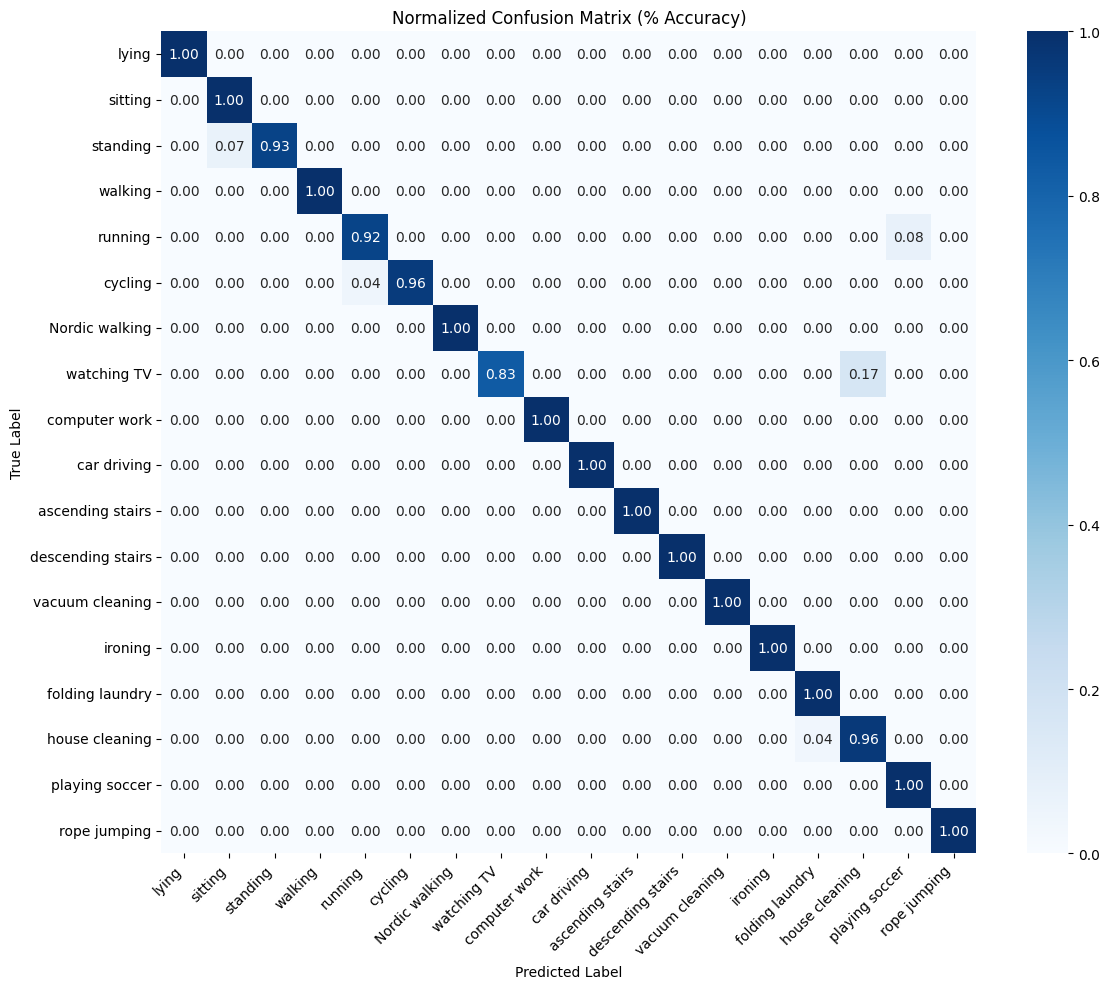

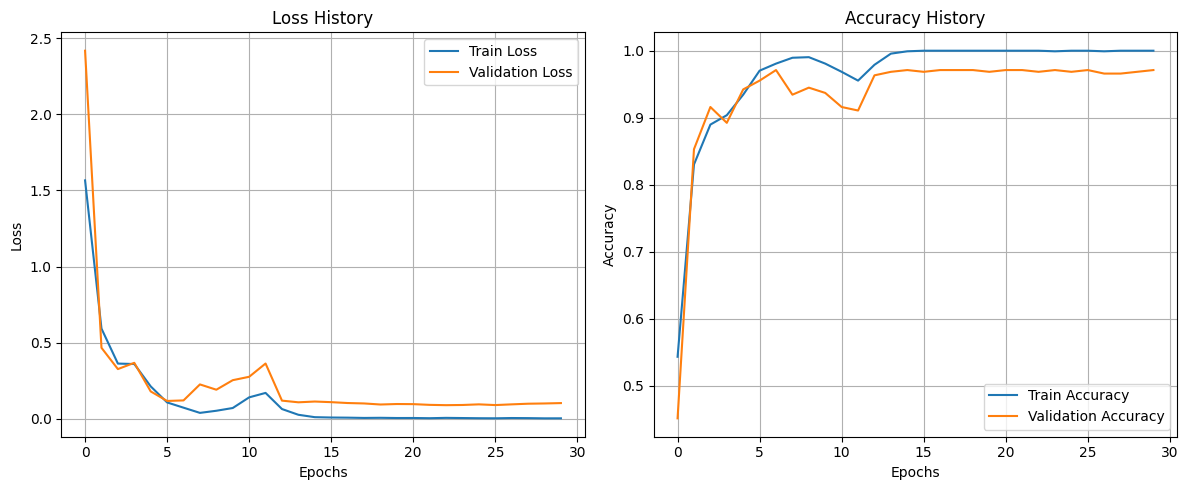


Final Test Accuracy: 0.9817


In [10]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

def evaluate_model(model, test_loader, device, class_names=None):
    """Evaluates the final model on the test dataset, reporting only accuracy and using PAMAP2 labels if none provided."""
    # PAMAP2 기본 라벨 (총 18개)
    pamap2_default_labels = [ # Renamed to avoid potential conflict
        "lying", "sitting", "standing", "walking", "running", "cycling", "Nordic walking",
        "watching TV", "computer work", "car driving", "ascending stairs", "descending stairs",
        "vacuum cleaning", "ironing", "folding laundry", "house cleaning", "playing soccer", "rope jumping"
    ]

    print("\n=== Final Model Evaluation (Test Set) ===")
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Overall Accuracy Calculation
    test_accuracy = accuracy_score(all_labels, all_preds)
    print(f"Test Accuracy: {test_accuracy:.4f}")

    # Classification Report and Confusion Matrix Preparation
    print("\nClassification Report:")
    unique_labels = np.unique(all_labels)

    # Determine which set of class names to use and ensure it's a list of strings
    report_names_list = None
    if class_names is not None and isinstance(class_names, list):
         # Check if provided class_names are sufficient and are strings
         if len(class_names) > unique_labels.max() and all(isinstance(n, str) for n in class_names):
             # Map the unique integer labels to their string names
             report_names_list = [class_names[int(i)] for i in unique_labels]
             if len(report_names_list) != len(unique_labels):
                  print("Warning: Mismatch between unique labels and provided class names list size after mapping. Using numerical labels.")
                  report_names_list = [str(i) for i in unique_labels] # Fallback to string representation of numbers
             else:
                print("Using provided class names.")
         else:
             print("Warning: Provided class_names are insufficient or not strings. Using PAMAP2 default labels.")
             # Map unique integer labels to default PAMAP2 names if within range
             if unique_labels.max() < len(pamap2_default_labels) and all(isinstance(n, str) for n in pamap2_default_labels):
                 report_names_list = [pamap2_default_labels[int(i)] for i in unique_labels]
             else:
                 print("Warning: Unique labels are out of range for PAMAP2 default labels. Using numerical labels.")
                 report_names_list = [str(i) for i in unique_labels] # Fallback to string representation of numbers
    else:
        print("No class_names provided or invalid type. Using PAMAP2 default labels.")
        # Map unique integer labels to default PAMAP2 names if within range
        if unique_labels.max() < len(pamap2_default_labels) and all(isinstance(n, str) for n in pamap2_default_labels):
            report_names_list = [pamap2_default_labels[int(i)] for i in unique_labels]
        else:
             print("Warning: Unique labels are out of range for PAMAP2 default labels. Using numerical labels.")
             report_names_list = [str(i) for i in unique_labels] # Fallback to string representation of numbers


    # Ensure report_names_list is used for both report and matrix
    print(classification_report(
        all_labels, all_preds,
        target_names=report_names_list, # Use the determined list of string names
        digits=4, zero_division=0
    ))

    # Calculate Normalized Confusion Matrix (accuracy per class)
    print("\nConfusion Matrix (Class-wise Accuracy):")
    # Use labels argument to ensure correct ordering in CM
    cm = confusion_matrix(all_labels, all_preds, labels=unique_labels, normalize='true')

    plt.figure(figsize=(12, 10))
    sns.heatmap(
        cm, annot=True, fmt='.2f', cmap='Blues',
        # Use report_names_list for both x and y tick labels
        xticklabels=report_names_list,
        yticklabels=report_names_list
    )
    plt.xlabel('Predicted Label') # Generic label
    plt.ylabel('True Label')   # Generic label
    plt.title('Normalized Confusion Matrix (% Accuracy)') # Generic title
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    return test_accuracy

# ==============================================================================
# Add this section back to make the script executable and runnable
if __name__ == '__main__':
    # The code block starting from # --- 1. Load and Window Data ---
    # and ending before the evaluate_model call should be present here.
    # For brevity, only the evaluation part is shown as the fix target.

    # ... [Previous code for data loading, splitting, scaling, dataset/dataloader creation, model training] ...

    # Assuming trained_model, test_loader, device, and CLASS_NAMES are available from the previous steps
    # --- 8. Evaluate the Final Model on Test Set ---
    test_accuracy = evaluate_model(model=trained_model,
                                   test_loader=test_loader,
                                   device=device,
                                   class_names=CLASS_NAMES) # Pass the loaded CLASS_NAMES

    # --- 9. Plot Training History ---
    # Assuming history is available from the training step
    if history:
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(history['train_loss'], label='Train Loss')
        plt.plot(history['val_loss'], label='Validation Loss')
        plt.title('Loss History')
        plt.xlabel('Epochs'); plt.ylabel('Loss'); plt.legend(); plt.grid(True)
        plt.subplot(1, 2, 2)
        plt.plot(history['train_acc'], label='Train Accuracy')
        plt.plot(history['val_acc'], label='Validation Accuracy')
        plt.title('Accuracy History')
        plt.xlabel('Epochs'); plt.ylabel('Accuracy'); plt.legend(); plt.grid(True)
        plt.tight_layout(); plt.show()
    else:
        print("\nNo history data to plot.")


    print(f"\nFinal Test Accuracy: {test_accuracy:.4f}")

Found 9 files for Train/Validation.
Found 2 files for Test.

Processing Train/Validation files...
  Processing file: S1-ADL1.dat...
  Processing file: S1-ADL2.dat...
  Processing file: S1-ADL3.dat...
  Processing file: S2-ADL1.dat...
  Processing file: S2-ADL2.dat...
  Processing file: S2-ADL3.dat...
  Processing file: S3-ADL1.dat...
  Processing file: S3-ADL2.dat...
  Processing file: S3-ADL3.dat...

Processing Test files...
  Processing file: S4-ADL4.dat...
  Processing file: S4-ADL5.dat...

Windowing complete.
  Train/Val windows: 8020
  Test windows: 2073

Label encoding done. Found 6 unique classes.
  Original Class IDs found: [  0 101 102 103 104 105]
  Mapped Class Names (0-indexed): ['Gesture_0', 'Gesture_101', 'Gesture_102', 'Gesture_103', 'Gesture_104', 'Gesture_105']

Data loading, windowing, splitting successful.
Input Channels: 113, Sequence Length: 24, Num Classes: 6
Class Names: ['Gesture_0', 'Gesture_101', 'Gesture_102', 'Gesture_103', 'Gesture_104', 'Gesture_105']

Dat

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/50 | Train Loss: 0.7231, Acc: 0.7352 | Val Loss: 0.5106, Acc: 0.7980
Epoch 2/50 | Train Loss: 0.3792, Acc: 0.8602 | Val Loss: 0.2902, Acc: 0.8978
Epoch 3/50 | Train Loss: 0.3190, Acc: 0.8881 | Val Loss: 0.2967, Acc: 0.9096
Epoch 4/50 | Train Loss: 0.2226, Acc: 0.9253 | Val Loss: 0.2791, Acc: 0.9190
Epoch 5/50 | Train Loss: 0.1537, Acc: 0.9431 | Val Loss: 0.2053, Acc: 0.9364
Epoch 6/50 | Train Loss: 0.1150, Acc: 0.9595 | Val Loss: 0.2051, Acc: 0.9258
Epoch 7/50 | Train Loss: 0.1941, Acc: 0.9257 | Val Loss: 0.1671, Acc: 0.9507
Epoch 8/50 | Train Loss: 0.0981, Acc: 0.9657 | Val Loss: 0.2057, Acc: 0.9451
Epoch 9/50 | Train Loss: 0.1073, Acc: 0.9677 | Val Loss: 0.2987, Acc: 0.9246
Epoch 10/50 | Train Loss: 0.0851, Acc: 0.9695 | Val Loss: 0.1789, Acc: 0.9539
Epoch 11/50 | Train Loss: 0.0907, Acc: 0.9709 | Val Loss: 0.1332, Acc: 0.9670
Epoch 12/50 | Train Loss: 0.0632, Acc: 0.9796 | Val Loss: 0.2207, Acc: 0.9532
Epoch 13/50 | Train Loss: 0.0457, Acc: 0.9860 | Val Loss: 0.1118, Acc: 0.

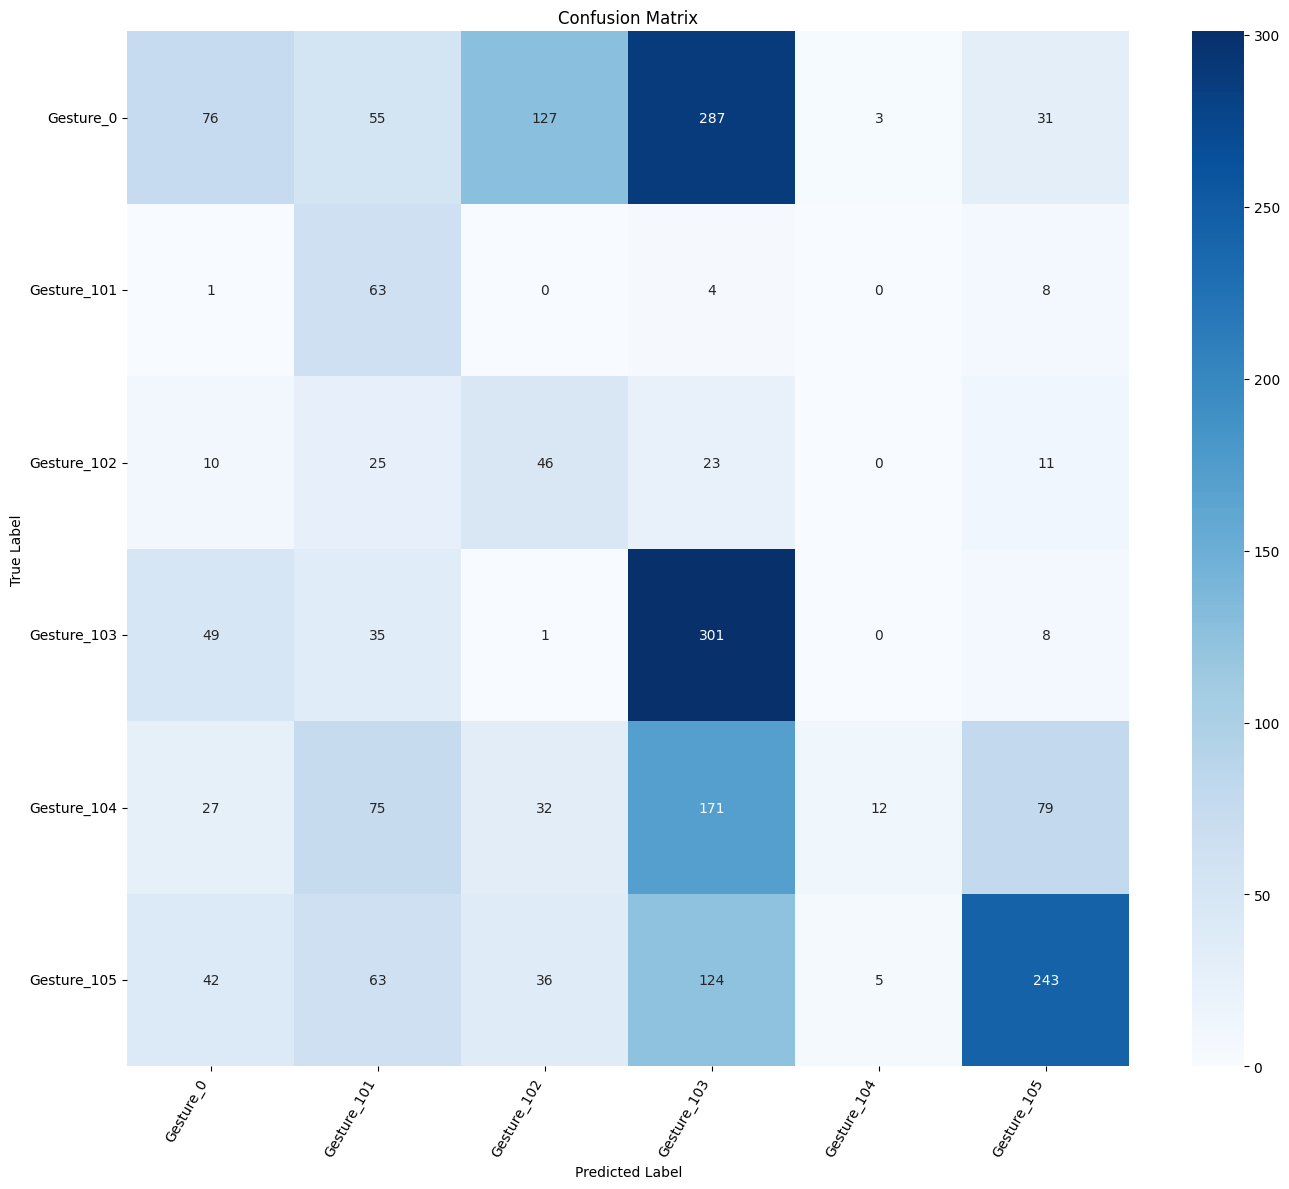

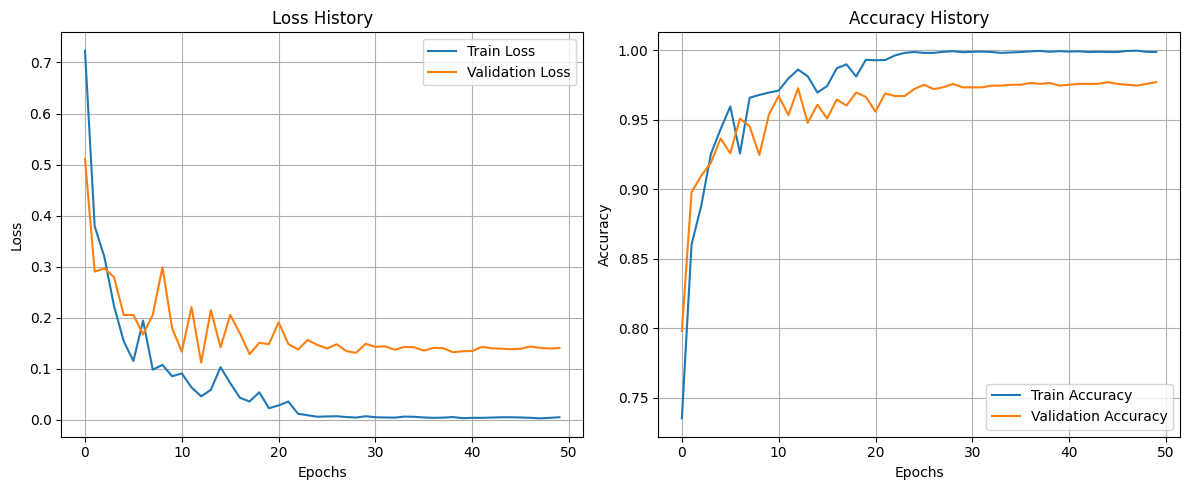


Final Test Accuracy: 0.3575
Final Test F1-score (Weighted): 0.3137


In [11]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import glob

# ---------------- Depthwise Separable Conv ----------------

class DepthwiseSeparableConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, padding, bias=False):
        super().__init__()
        self.depthwise = nn.Conv1d(in_channels, in_channels, kernel_size=kernel_size, padding=padding, groups=in_channels, bias=bias)
        self.pointwise = nn.Conv1d(in_channels, out_channels, kernel_size=1, bias=bias)
        self.bn = nn.BatchNorm1d(out_channels)
        self.relu = nn.ReLU(inplace=True)
    def forward(self, x):
        x = self.depthwise(x); x = self.pointwise(x); x = self.bn(x); return self.relu(x)

# ---------------- MultiKernalBlock ----------------

class MultiKernalBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.skip_proj = nn.Conv1d(in_channels, out_channels * 4, kernel_size=1, bias=False); self.bn_skip = nn.BatchNorm1d(out_channels * 4)
        self.branch7 = DepthwiseSeparableConv(in_channels, out_channels, kernel_size=7, padding=3); self.branch5 = DepthwiseSeparableConv(out_channels, out_channels, kernel_size=5, padding=2)
        self.branch3 = DepthwiseSeparableConv(out_channels, out_channels, kernel_size=3, padding=1); self.branch1 = DepthwiseSeparableConv(out_channels, out_channels, kernel_size=1, padding=0)
    def forward(self, x):
        identity = self.bn_skip(self.skip_proj(x)); x7 = self.branch7(x); x5 = self.branch5(x7); x3 = self.branch3(x5); x1 = self.branch1(x3)
        out = torch.cat([x1, x3, x5, x7], dim=1); out = out + identity; return F.relu(out)

# ---------------- InceptionBlock ----------------
class InceptionBlock(nn.Module):
    def __init__(self, in_channels, out_channels_per_branch):
        super().__init__()
        total_out_channels = out_channels_per_branch * 4
        self.skip_proj = nn.Conv1d(in_channels, total_out_channels, kernel_size=1, bias=False); self.bn_skip = nn.BatchNorm1d(total_out_channels)
        self.branch1 = DepthwiseSeparableConv(in_channels, out_channels_per_branch, kernel_size=1, padding=0)
        self.branch3 = nn.Sequential(DepthwiseSeparableConv(in_channels, out_channels_per_branch, kernel_size=1, padding=0), DepthwiseSeparableConv(out_channels_per_branch, out_channels_per_branch, kernel_size=3, padding=1))
        self.branch5 = nn.Sequential(DepthwiseSeparableConv(in_channels, out_channels_per_branch, kernel_size=1, padding=0), DepthwiseSeparableConv(out_channels_per_branch, out_channels_per_branch, kernel_size=5, padding=2))
        self.pool = nn.Sequential(nn.MaxPool1d(kernel_size=3, stride=1, padding=1), DepthwiseSeparableConv(in_channels, out_channels_per_branch, kernel_size=1, padding=0))
    def forward(self, x):
        identity = self.bn_skip(self.skip_proj(x)); b1 = self.branch1(x); b3 = self.branch3(x); b5 = self.branch5(x); bp = self.pool(x)
        out = torch.cat([b1, b3, b5, bp], dim=1); out = out + identity; return F.relu(out)

# ---------------- ResidualBlock----------------
class ResidualBlock(nn.Module):
    def __init__(self, channels, kernel_size=3):
        super().__init__(); self.conv1 = nn.Conv1d(channels, channels, kernel_size, padding=kernel_size // 2, bias=False); self.bn1 = nn.BatchNorm1d(channels); self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv1d(channels, channels, kernel_size, padding=kernel_size // 2, bias=False); self.bn2 = nn.BatchNorm1d(channels)
    def forward(self, x):
        residual = x; out = self.conv1(x); out = self.bn1(out); out = self.relu(out); out = self.conv2(out); out = self.bn2(out); out += residual; return self.relu(out)

# ---------------- TransformerEncoderBlock ----------------
class TransformerEncoderBlock(nn.Module):
    def __init__(self, dim, num_heads, dropout=0.1):
        super().__init__(); self.attn = nn.MultiheadAttention(embed_dim=dim, num_heads=num_heads, batch_first=True, dropout=dropout)
        self.ffn = nn.Sequential(nn.Linear(dim, dim * 4), nn.ReLU(), nn.Dropout(dropout), nn.Linear(dim * 4, dim))
        self.norm1 = nn.LayerNorm(dim); self.norm2 = nn.LayerNorm(dim); self.dropout = nn.Dropout(dropout)
    def forward(self, x):
        x_norm1 = self.norm1(x); attn_out, _ = self.attn(x_norm1, x_norm1, x_norm1); x = x + self.dropout(attn_out)
        x_norm2 = self.norm2(x); ffn_out = self.ffn(x_norm2); x = x + self.dropout(ffn_out); return x

# ---------------- InceptionFormer ----------------
class InceptionFormer(nn.Module):
    def __init__(self, input_channels=9, feature_dim=64, num_classes=6, num_transformer_layers=2, num_heads=4, dropout=0.1):
        super().__init__()
        self.input_proj = nn.Conv1d(input_channels, feature_dim, kernel_size=1, bias=False); self.input_bn = nn.BatchNorm1d(feature_dim)
        self.inception = InceptionBlock(feature_dim, feature_dim); self.mkls = MultiKernalBlock(feature_dim * 4, feature_dim)
        self.residual1 = ResidualBlock(feature_dim * 4)
        self.transformer_layers = nn.ModuleList([TransformerEncoderBlock(dim=feature_dim * 4, num_heads=num_heads, dropout=dropout) for _ in range(num_transformer_layers)])
        self.gap = nn.AdaptiveAvgPool1d(1); self.flatten = nn.Flatten()
        self.classifier = nn.Sequential(nn.LayerNorm(feature_dim * 4), nn.Linear(feature_dim * 4, 128), nn.ReLU(), nn.Dropout(dropout), nn.Linear(128, num_classes))
    def forward(self, x):
        x = F.relu(self.input_bn(self.input_proj(x))); x = self.inception(x); x = self.mkls(x); x = self.residual1(x)
        x = x.permute(0, 2, 1);
        for layer in self.transformer_layers: x = layer(x)
        x = x.permute(0, 2, 1); x = self.gap(x); x = self.flatten(x); return self.classifier(x)

# ==============================================================================
# Data Loading and Dataset for OPPORTUNITY
# ==============================================================================

def process_opportunity_files(file_list, sensor_columns_indices, label_column_index, window_size, step):
    """Helper function to load, clean (remove NaN rows), and window data from a list of Opportunity files."""
    all_windows = []
    all_original_labels = []  # Store original labels before encoding

    for file_path in file_list:
        print(f"  Processing file: {os.path.basename(file_path)}...")
        try:
            df = pd.read_csv(file_path, sep='\s+', header=None, low_memory=False)

            # --- Handle NaNs by removing rows ---
            # 1. Select only relevant columns early to reduce memory/computation
            relevant_cols = list(sensor_columns_indices) + [label_column_index]
            df = df.iloc[:, relevant_cols]
            # Rename label column temporarily for clarity
            df.rename(columns={label_column_index: 'label'}, inplace=True)

            # 2. Remove any rows that contain NaN values (instead of interpolating/filling)
            df.dropna(inplace=True)

            # Convert features and labels after cleaning
            features = df.iloc[:, :len(sensor_columns_indices)].values.astype(np.float32)
            labels = df['label'].values.astype(int)

            # --- Windowing ---
            start = 0
            while start + window_size <= len(features):
                window_data = features[start : start + window_size, :]  # (window_size, num_features)
                window_labels_raw = labels[start : start + window_size]

                # Label: Use mode (most frequent label in the window)
                label_counts = Counter(window_labels_raw)
                if not label_counts:
                    start += step
                    continue
                most_common_label = label_counts.most_common(1)[0][0]

                all_windows.append(window_data)
                all_original_labels.append(most_common_label)
                start += step

        except FileNotFoundError:
            print(f"    Warning: File not found {file_path}. Skipping.")
        except pd.errors.EmptyDataError:
            print(f"    Warning: File {file_path} is empty or contains no valid data. Skipping.")
        except Exception as e:
            print(f"    Error processing {file_path}: {e}")

    if not all_windows:
        return None, None

    # Convert to numpy array and transpose features
    X_windowed = np.array(all_windows, dtype=np.float32)
    # Transpose features to (N, C, L) for Conv1D input
    X_windowed = np.transpose(X_windowed, (0, 2, 1))
    y_original = np.array(all_original_labels, dtype=int)

    return X_windowed, y_original



def load_and_split_opportunity(dataset_dir, sensor_columns_indices, label_column_index, window_size, step, val_split_size=0.2, random_state=42):
    """Loads Opportunity data, applies standard split, cleans, windows, encodes, and returns train/val/test sets."""

    # Standard Opportunity Split Protocol
    train_val_subjects = ['S1', 'S2', 'S3']
    test_subjects = ['S4']
    train_val_trials = ['ADL1', 'ADL2', 'ADL3']
    test_trials = ['ADL4', 'ADL5']

    # Find relevant files
    all_files = glob.glob(os.path.join(dataset_dir, "dataset", "*.dat")) # Data is often in a 'dataset' subdirectory
    if not all_files:
         print(f"Error: No '.dat' files found in {os.path.join(dataset_dir, 'dataset')}. Check path.")
         return None

    train_val_files = [f for f in all_files if any(s in os.path.basename(f) for s in train_val_subjects) and any(t in os.path.basename(f) for t in train_val_trials)]
    test_files = [f for f in all_files if any(s in os.path.basename(f) for s in test_subjects) and any(t in os.path.basename(f) for t in test_trials)]

    print(f"Found {len(train_val_files)} files for Train/Validation.")
    print(f"Found {len(test_files)} files for Test.")
    if not train_val_files or not test_files:
        print("Error: Could not find necessary files for standard train/test split. Check dataset structure/naming.")
        return None

    # Process Train/Val files
    print("\nProcessing Train/Validation files...")
    X_train_val, y_train_val_orig = process_opportunity_files(train_val_files, sensor_columns_indices, label_column_index, window_size, step)
    if X_train_val is None: return None

    # Process Test files
    print("\nProcessing Test files...")
    X_test, y_test_orig = process_opportunity_files(test_files, sensor_columns_indices, label_column_index, window_size, step)
    if X_test is None: return None

    print("\nWindowing complete.")
    print(f"  Train/Val windows: {X_train_val.shape[0]}")
    print(f"  Test windows: {X_test.shape[0]}")

    # --- Label Encoding ---
    # Fit encoder on combined labels from train/val and test sets to ensure consistency
    combined_labels_orig = np.concatenate([y_train_val_orig, y_test_orig])
    label_encoder = LabelEncoder()
    label_encoder.fit(combined_labels_orig) # Fit on original labels (e.g., 0, 2, 4, 5...)

    # Generate class names based on the original labels found
    original_class_ids = label_encoder.classes_
    class_names = [f'Gesture_{orig_id}' for orig_id in original_class_ids] # Generic names
    num_classes = len(class_names)

    print(f"\nLabel encoding done. Found {num_classes} unique classes.")
    print(f"  Original Class IDs found: {original_class_ids}")
    print(f"  Mapped Class Names (0-indexed): {class_names}")

    # Transform labels to 0-indexed encoded values
    y_train_val_encoded = label_encoder.transform(y_train_val_orig)
    y_test_encoded = label_encoder.transform(y_test_orig)

    # --- Split Train/Validation ---
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_val, y_train_val_encoded,
        test_size=val_split_size,
        random_state=random_state,
        stratify=y_train_val_encoded # Stratify based on encoded labels
    )

    return X_train, y_train, X_val, y_val, X_test, y_test_encoded, class_names, num_classes


class OpportunityDataset(Dataset): # Renamed Dataset class
    """Opportunity windowed data PyTorch Dataset"""
    def __init__(self, data, labels):
        if data.ndim != 3:
             raise ValueError(f"Data needs to be 3D (samples, channels, sequence), but got {data.shape}")
        self.data = torch.tensor(data, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)
    def __len__(self): return len(self.labels)
    def __getitem__(self, idx): return self.data[idx], self.labels[idx] # Data is already (N, C, L)

def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, device, epochs=20, patience=None):
    """Trains and validates the model without early stopping.
       The 'patience' parameter is included for compatibility but is not used.
    """
    print(f"\n=== Model Training Started (Device: {device}) ===")
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    for epoch in range(epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        epoch_train_loss = running_loss / total_train
        epoch_train_acc = correct_train / total_train
        history['train_loss'].append(epoch_train_loss)
        history['train_acc'].append(epoch_train_acc)

        # Validation phase
        model.eval()
        running_val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item() * inputs.size(0)

                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        epoch_val_loss = running_val_loss / total_val
        epoch_val_acc = correct_val / total_val
        history['val_loss'].append(epoch_val_loss)
        history['val_acc'].append(epoch_val_acc)

        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {epoch_train_loss:.4f}, Acc: {epoch_train_acc:.4f} | "
              f"Val Loss: {epoch_val_loss:.4f}, Acc: {epoch_val_acc:.4f}")

        # Learning rate scheduler update
        current_lr = optimizer.param_groups[0]['lr']  # Get current learning rate
        scheduler.step(epoch_val_loss)
        if optimizer.param_groups[0]['lr'] < current_lr:
            print("  -> Learning rate reduced by scheduler.")

    print("=== Training Finished ===")
    return model, history




def evaluate_model(model, test_loader, criterion, device, class_names):
    """Evaluates the final model on the test dataset."""
    print("\n=== Final Model Evaluation (Test Set) ===")
    model.eval(); running_test_loss = 0.0; all_preds, all_labels = [], []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device); outputs = model(inputs)
            if criterion is not None: loss = criterion(outputs, labels); running_test_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1); all_preds.extend(predicted.cpu().numpy()); all_labels.extend(labels.cpu().numpy())

    test_loss = running_test_loss / len(test_loader.dataset) if criterion is not None and len(test_loader.dataset) > 0 else -1.0
    test_accuracy = accuracy_score(all_labels, all_preds)
    # Calculate weighted F1-score (often used for Opportunity)

    test_f1_weighted = f1_score(all_labels, all_preds, average='weighted', zero_division=0)
    print(f"Test Loss: {test_loss:.4f}" if test_loss != -1.0 else "Test Loss: N/A")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(f"Test F1-score (Weighted): {test_f1_weighted:.4f}") # Added F1 score
    print("\nClassification Report:")

    unique_labels_in_test = np.unique(all_labels)
    report_targets=[class_names[i] for i in unique_labels_in_test if i < len(class_names)]
    if len(report_targets) != len(unique_labels_in_test) : print("Warning: Label mismatch for report/CM."); report_targets = None; cm_labels = unique_labels_in_test
    else: cm_labels = report_targets
    print(classification_report(all_labels, all_preds, target_names=report_targets, digits=4, zero_division=0))
    print("\nConfusion Matrix:")

    cm = confusion_matrix(all_labels, all_preds); plt.figure(figsize=(14, 12)) # Adjusted size
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=cm_labels, yticklabels=cm_labels)
    plt.xlabel('Predicted Label'); plt.ylabel('True Label'); plt.title('Confusion Matrix'); plt.xticks(rotation=60, ha='right'); plt.yticks(rotation=0)
    plt.tight_layout(); plt.show()
    return test_loss, test_accuracy, test_f1_weighted # Return F1 score


# ==============================================================================
if __name__ == '__main__':

    OPPORTUNITY_DATASET_PATH = '/content/drive/MyDrive/Colab Notebooks/OpportunityUCIDataset/'
    RANDOM_STATE = 42

    # Opportunity Column Indices (0-based). Verify based on your dataset version!
    # Using 113 sensor channels (Timestamp is col 0, sensors 1-113)
    # Columns 1 to 113 inclusive -> Indices 1 to 113

    SENSOR_COLUMN_INDICES = list(range(1, 114)) # 113 channels
    # Target Label: High-level Gestures (Check index in ColumnNames.txt or description)
    LABEL_COLUMN_INDEX = 244 # Often index 244 (0-based) for high-level activity/gesture

    INPUT_CHANNELS = len(SENSOR_COLUMN_INDICES) # Should be 113

    # Windowing Parameters (Opportunity is ~30Hz)
    WINDOW_SIZE = 24       # As used in original Opportunity challenge paper
    STEP = 12              # 50% overlap

    # Data Splitting Parameters (Handled internally by load_and_split_opportunity)
    VAL_SPLIT_SIZE = 0.2   # Validation split from the S1-S3 data

    # Training Parameters
    BATCH_SIZE = 128       # Increased batch size
    EPOCHS = 50           # Opportunity often requires more epochs
    LEARNING_RATE = 0.0005
    PATIENCE = 15          # Increased patience

    # Model Parameters
    FEATURE_DIM = 128
    NUM_TRANSFORMER_LAYERS = 3
    NUM_HEADS = 8
    DROPOUT = 0.3          # Increased dropout for potentially complex data

    # Set seed for reproducibility
    np.random.seed(RANDOM_STATE)
    torch.manual_seed(RANDOM_STATE)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(RANDOM_STATE)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

    # --- 1. Load, Window, and Split Data ---
    result = load_and_split_opportunity(
        dataset_dir=OPPORTUNITY_DATASET_PATH,
        sensor_columns_indices=SENSOR_COLUMN_INDICES,
        label_column_index=LABEL_COLUMN_INDEX,
        window_size=WINDOW_SIZE,
        step=STEP,
        val_split_size=VAL_SPLIT_SIZE,
        random_state=RANDOM_STATE
    )

    if result is not None:
        X_train, y_train, X_val, y_val, X_test, y_test, CLASS_NAMES, NUM_CLASSES = result
        SEQUENCE_LENGTH = X_train.shape[2] # Should be WINDOW_SIZE

        print(f"\nData loading, windowing, splitting successful.")
        print(f"Input Channels: {INPUT_CHANNELS}, Sequence Length: {SEQUENCE_LENGTH}, Num Classes: {NUM_CLASSES}")
        print(f"Class Names: {CLASS_NAMES}")
        print("\nData Split Shapes:")
        print(f"  Train: X={X_train.shape}, y={y_train.shape}")
        print(f"  Val:   X={X_val.shape}, y={y_val.shape}")
        print(f"  Test:  X={X_test.shape}, y={y_test.shape}")

        # --- 2. Apply Scaling (Fit on Train only) ---
        scaler = StandardScaler()
        n_train, c_train, l_train = X_train.shape; X_train_reshaped = X_train.transpose(0, 2, 1).reshape(-1, c_train)
        scaler.fit(X_train_reshaped); X_train_scaled_reshaped = scaler.transform(X_train_reshaped)
        X_train = X_train_scaled_reshaped.reshape(n_train, l_train, c_train).transpose(0, 2, 1)
        n_val, c_val, l_val = X_val.shape; X_val_reshaped = X_val.transpose(0, 2, 1).reshape(-1, c_val)
        X_val_scaled_reshaped = scaler.transform(X_val_reshaped); X_val = X_val_scaled_reshaped.reshape(n_val, l_val, c_val).transpose(0, 2, 1)
        n_test, c_test, l_test = X_test.shape; X_test_reshaped = X_test.transpose(0, 2, 1).reshape(-1, c_test)
        X_test_scaled_reshaped = scaler.transform(X_test_reshaped); X_test = X_test_scaled_reshaped.reshape(n_test, l_test, c_test).transpose(0, 2, 1)
        print("Data scaling applied (fitted on train set).")

        # --- 3. Calculate Class Weights ---
        # Include Null class if present (which is standard)
        class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
        class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32)
        print(f"\nClass Weights (for training loss): {class_weights}")

        # --- 4. Create Datasets and DataLoaders ---
        train_dataset = OpportunityDataset(X_train, y_train) # Use renamed dataset
        val_dataset = OpportunityDataset(X_val, y_val)
        test_dataset = OpportunityDataset(X_test, y_test)
        train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
        val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE * 2, shuffle=False, num_workers=2, pin_memory=True)
        test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE * 2, shuffle=False, num_workers=2, pin_memory=True)
        print("DataLoaders created.")

        # --- 5. Initialize Model, Loss, Optimizer, Scheduler ---
        model = InceptionFormer(input_channels=INPUT_CHANNELS, # Updated Input Channels
                                feature_dim=FEATURE_DIM,
                                num_classes=NUM_CLASSES,      # Updated Num Classes
                                num_transformer_layers=NUM_TRANSFORMER_LAYERS,
                                num_heads=NUM_HEADS,
                                dropout=DROPOUT)
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model.to(device); class_weights_tensor = class_weights_tensor.to(device)
        criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
        optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=0.01)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.2, patience=7, verbose=True) # Adjusted patience

        print(f"\nModel Initialized: {type(model).__name__}"); print(f"  Input Channels: {INPUT_CHANNELS}, Num Classes: {NUM_CLASSES}")
        print(f"Using device: {device}")

        # --- 6. Train the Model ---
        trained_model, history = train_model(model=model, train_loader=train_loader, val_loader=val_loader, criterion=criterion,
                                             optimizer=optimizer, scheduler=scheduler, device=device, epochs=EPOCHS, patience=PATIENCE)


        # --- 7. Evaluate the Final Model ---
        test_loss, test_accuracy, test_f1_weighted = evaluate_model(model=trained_model, test_loader=test_loader, criterion=criterion,
                                                device=device, class_names=CLASS_NAMES) # Use CLASS_NAMES from data loading

        # --- 8. Plot Training History ---
        if history:
            plt.figure(figsize=(12, 5)); plt.subplot(1, 2, 1)
            plt.plot(history['train_loss'], label='Train Loss'); plt.plot(history['val_loss'], label='Validation Loss')
            plt.title('Loss History'); plt.xlabel('Epochs'); plt.ylabel('Loss'); plt.legend(); plt.grid(True)
            plt.subplot(1, 2, 2)
            plt.plot(history['train_acc'], label='Train Accuracy'); plt.plot(history['val_acc'], label='Validation Accuracy')
            plt.title('Accuracy History'); plt.xlabel('Epochs'); plt.ylabel('Accuracy'); plt.legend(); plt.grid(True)
            plt.tight_layout(); plt.show()
        else: print("\nNo history data to plot.")

        print(f"\nFinal Test Accuracy: {test_accuracy:.4f}")
        print(f"Final Test F1-score (Weighted): {test_f1_weighted:.4f}") # Print F1 score

    else:
        print("\nData loading or windowing failed for Opportunity. Exiting.")